<a href="https://colab.research.google.com/github/vornitier/stable_diffusion/blob/main/dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Huggingface Dreambooth Hackathon

In [ ]:
%pip install -qqU diffusers transformers bitsandbytes accelerate ftfy datasets

     |████████████████████████████████| 524 kB 31.5 MB/s 
     |████████████████████████████████| 5.8 MB 62.6 MB/s 
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 191 kB 79.3 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 452 kB 48.4 MB/s 
     |████████████████████████████████| 182 kB 63.8 MB/s 
     |████████████████████████████████| 7.6 MB 65.8 MB/s 
     |████████████████████████████████| 212 kB 82.3 MB/s 
     |████████████████████████████████| 132 kB 82.4 MB/s 
     |████████████████████████████████| 127 kB 79.3 MB/s 


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import ipywidgets as widgets

theme = "wildcard"
drop_down = widgets.Dropdown(
    options=["animal", "science", "food", "landscape", "wildcard"],
    description="Pick a theme",
    disabled=False,
)

def dropdown_handler(change):
    global theme
    theme = change.new

drop_down.observe(dropdown_handler, names="value")
display(drop_down)

Dropdown(description='Pick a theme', options=('animal', 'science', 'food', 'landscape', 'wildcard'), value='an…

In [ ]:
print(f"You've selected the {theme} theme!")

You've selected the wildcard theme!


In [ ]:
from datasets import load_dataset
from os import mkdir

# create directory where we store the images.
!mkdir diffusion


mkdir: cannot create directory ‘diffusion’: File exists


In [ ]:
dataset = load_dataset("imagefolder", data_dir="/content/diffusion/")

# Push to huggingface hub. rename our dataset here.
dataset.push_to_hub("dreambooth-hackathon-images")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Load our dataset
from datasets import load_dataset

dataset_id = "Verne/dreambooth-hackathon-images"  # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Verne___parquet/Verne--dreambooth-hackathon-images-63afbe4685404324/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image'],
    num_rows: 20
})

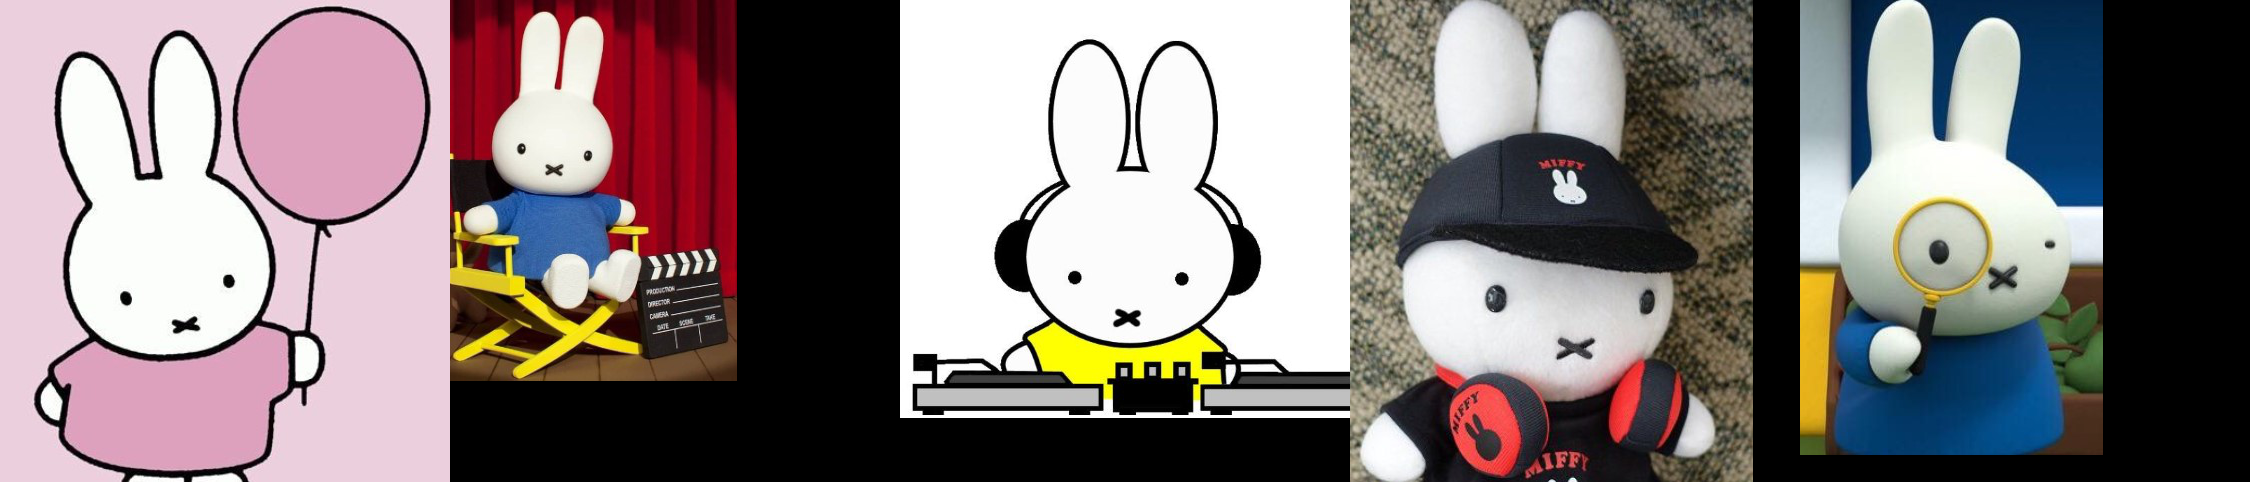

In [ ]:
# View first few images.
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 5
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

Create Training Dataset

In [ ]:
name_of_your_concept = "miffy"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "rabbit"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of miffy rabbit


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [ ]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

{'instance_images': tensor([[[0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          ...,
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431]],
 
         [[0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235],
          [0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235],
          [0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235],
          ...,
          [0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235],
          [0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235],
          [0.6235, 0.6235, 0.6235,  ..., 0.6235, 0.6235, 0.6235]],
 
         [[0.7333, 0.7333, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
          [0.7333, 0.7333, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
          [0.7333, 0.

In [ ]:
# data collator. converts your tokens into a single tensor to provide to the model..
import torch

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

In [ ]:
# Load components of stable diffusion pipeline.

from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

# Finetune Model

In [ ]:
# Our parameters.

learning_rate = 2e-06
max_train_steps = 400

from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=64, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # where to save the pipeline
)

In [ ]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


Downloading:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [ ]:
# use this to free up memory.
with torch.no_grad():
    torch.cuda.empty_cache()

Inference

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

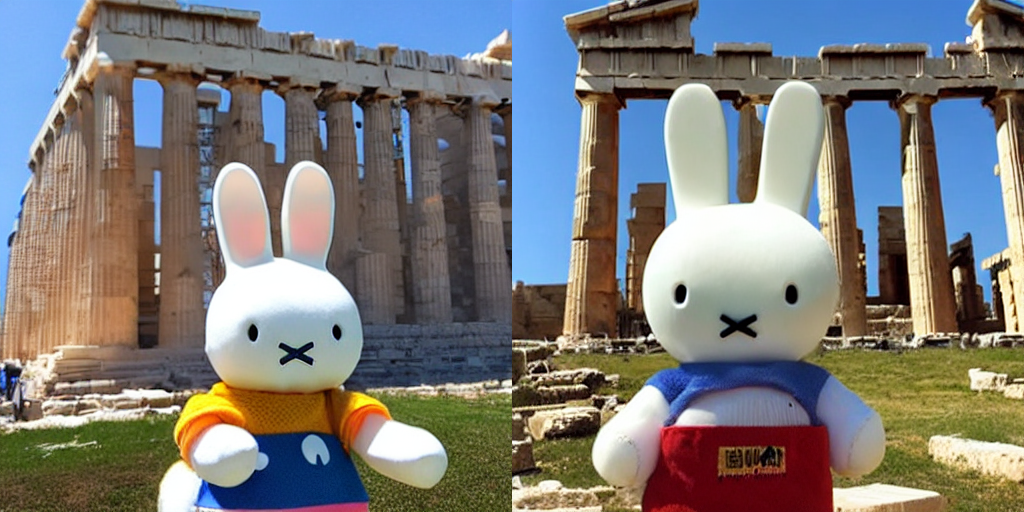

In [ ]:
# Pick a funny prompt here and it will be used as the widget's default
# when we push to the Hub in the next section
prompt = f"a photo of {name_of_your_concept} {type_of_thing} in the Acropolis"

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

# Push model to the hub

In [ ]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f"{name_of_your_concept}-{type_of_thing}"

In [ ]:
# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images for the {theme} theme.
"""

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard")

Upload successful! Model can be found here: https://huggingface.co/Verne/miffy-rabbit/blob/main/README.md
View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard
